# Trinucleotide Matrix Analysis Demo

This notebook demonstrates the `trinucleotideMatrix()` method for mutational signature analysis in pyMut.

The method generates a 96 x samples matrix representing trinucleotide contexts for all SNVs in the dataset.


## Setup and Imports


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add src to path if running from examples directory
if 'src' not in sys.path:
    sys.path.insert(0, '../../src')

from pyMut.input import read_maf
from pyMut.analysis.mutational_signature import add_trinucleotide_method_to_pymutation

# Add the method to PyMutation class
add_trinucleotide_method_to_pymutation()

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✓ Setup complete")


✓ Setup complete


## Data Loading


In [2]:
# Define file paths
maf_file = "../../src/pyMut/data/examples/tcga_laml.maf.gz"
fasta_file = "../../src/pyMut/data/resources/genome/GRCh37/GRCh37.p13.genome.fa"

# Check if files exist
if not os.path.exists(maf_file):
    print(f"❌ MAF file not found: {maf_file}")
else:
    print(f"✓ MAF file found")

if not os.path.exists(fasta_file):
    print(f"❌ FASTA file not found: {fasta_file}")
else:
    print(f"✓ FASTA file found")


✓ MAF file found
✓ FASTA file found


In [3]:
# Load the MAF file
pymut = read_maf(maf_file)

print(f"✓ Loaded {len(pymut.data):,} mutations")
print(f"✓ Data shape: {pymut.data.shape}")


2025-07-17 01:17:03,258 | INFO | pyMut.input | Starting MAF reading: ../../src/pyMut/data/examples/tcga_laml.maf.gz
2025-07-17 01:17:03,259 | INFO | pyMut.input | Loading from cache: ../../src/pyMut/data/examples/.pymut_cache/tcga_laml.maf_390b70c1a6ad2a7a.parquet
2025-07-17 01:17:03,284 | INFO | pyMut.input | Cache loaded successfully in 0.03 seconds


✓ Loaded 2,207 mutations
✓ Data shape: (2207, 216)


## Trinucleotide Matrix Generation


In [4]:
# Generate trinucleotide context matrix
contexts_df, enriched_data = pymut.trinucleotideMatrix(fasta_file)

print(f"✓ Generated {contexts_df.shape[0]} x {contexts_df.shape[1]} trinucleotide matrix")
print(f"✓ Processed {len(enriched_data):,} SNVs with valid contexts")
print(f"✓ Total mutations in matrix: {contexts_df.sum().sum():,}")


2025-07-17 01:17:03,319 | INFO | pyMut.analysis.mutational_signature | Detected long format with Tumor_Sample_Barcode column
2025-07-17 01:17:03,327 | INFO | pyMut.analysis.mutational_signature | Processing 2002 SNVs from 2207 total mutations
2025-07-17 01:17:03,328 | INFO | pyMut.analysis.mutational_signature | Loaded FASTA file: ../../src/pyMut/data/resources/genome/GRCh37/GRCh37.p13.genome.fa
2025-07-17 01:17:03,439 | INFO | pyMut.analysis.mutational_signature | Successfully processed 2002 SNVs with valid trinucleotide contexts
2025-07-17 01:17:03,614 | INFO | pyMut.analysis.mutational_signature | Generated 96 x 188 trinucleotide context matrix


✓ Generated 96 x 188 trinucleotide matrix
✓ Processed 2,002 SNVs with valid contexts
✓ Total mutations in matrix: 2,002


## Matrix Overview


In [5]:
# Basic statistics
total_mutations = contexts_df.sum().sum()
non_zero_contexts = (contexts_df > 0).sum().sum()
avg_mutations_per_sample = total_mutations / contexts_df.shape[1]

# Create summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Total Contexts', 'Total Samples', 'Total Mutations', 
               'Non-zero Contexts', 'Avg Mutations/Sample'],
    'Value': [contexts_df.shape[0], contexts_df.shape[1], total_mutations,
              non_zero_contexts, f"{avg_mutations_per_sample:.1f}"]
})

print("Matrix Summary:")
print(summary_stats.to_string(index=False))


Matrix Summary:
              Metric Value
      Total Contexts    96
       Total Samples   188
     Total Mutations  2002
   Non-zero Contexts  1584
Avg Mutations/Sample  10.6


## Top Trinucleotide Contexts


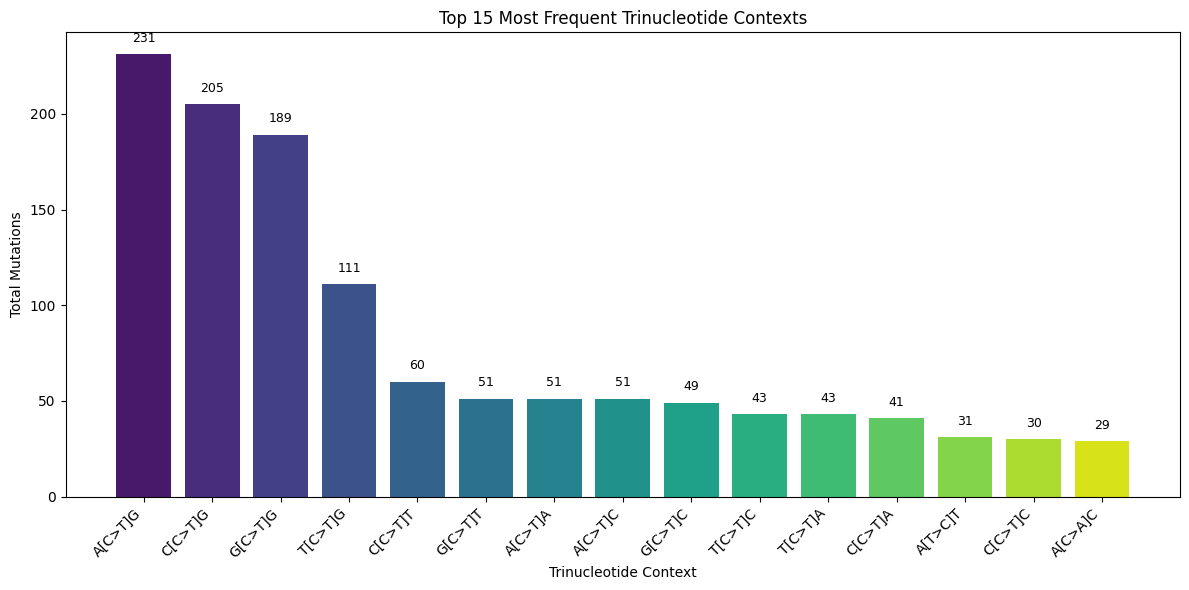

In [6]:
# Calculate context totals and plot top 15
context_totals = contexts_df.sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
top_contexts = context_totals.head(15)
bars = plt.bar(range(len(top_contexts)), top_contexts.values, 
               color=sns.color_palette("viridis", len(top_contexts)))
plt.xlabel('Trinucleotide Context')
plt.ylabel('Total Mutations')
plt.title('Top 15 Most Frequent Trinucleotide Contexts')
plt.xticks(range(len(top_contexts)), top_contexts.index, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Sample Distribution


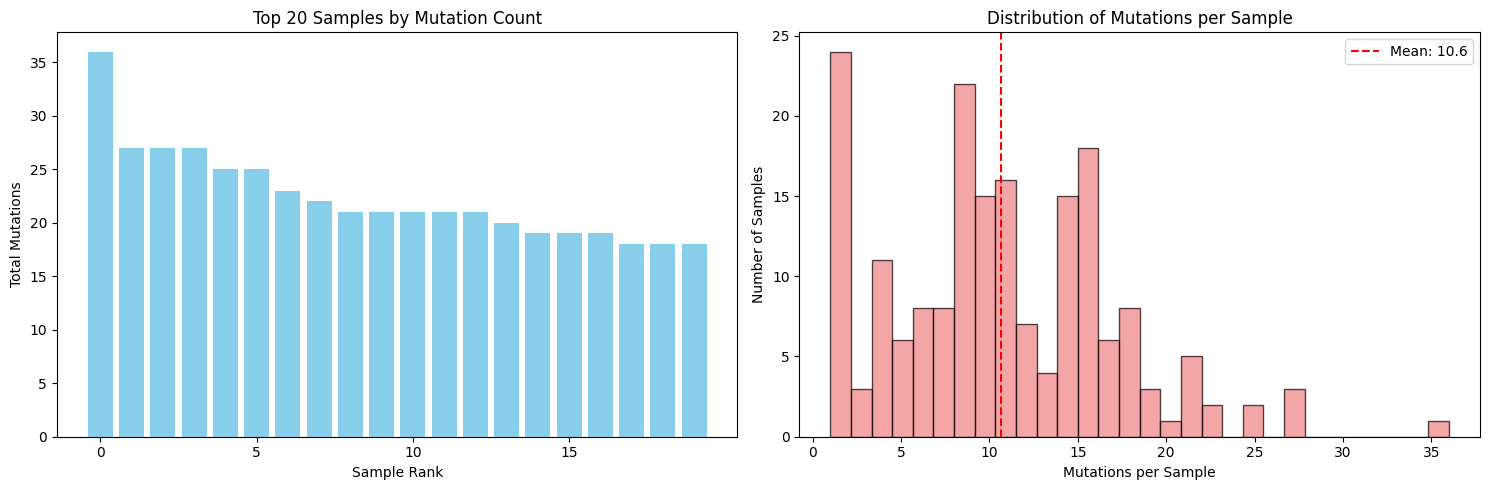

In [7]:
# Sample mutation counts
sample_totals = contexts_df.sum(axis=0).sort_values(ascending=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Top 20 samples
top_samples = sample_totals.head(20)
ax1.bar(range(len(top_samples)), top_samples.values, color='skyblue')
ax1.set_xlabel('Sample Rank')
ax1.set_ylabel('Total Mutations')
ax1.set_title('Top 20 Samples by Mutation Count')
ax1.set_xticks(range(0, len(top_samples), 5))

# Distribution histogram
ax2.hist(sample_totals.values, bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Mutations per Sample')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Distribution of Mutations per Sample')
ax2.axvline(sample_totals.mean(), color='red', linestyle='--', 
            label=f'Mean: {sample_totals.mean():.1f}')
ax2.legend()

plt.tight_layout()
plt.show()


## Mutation Type Distribution


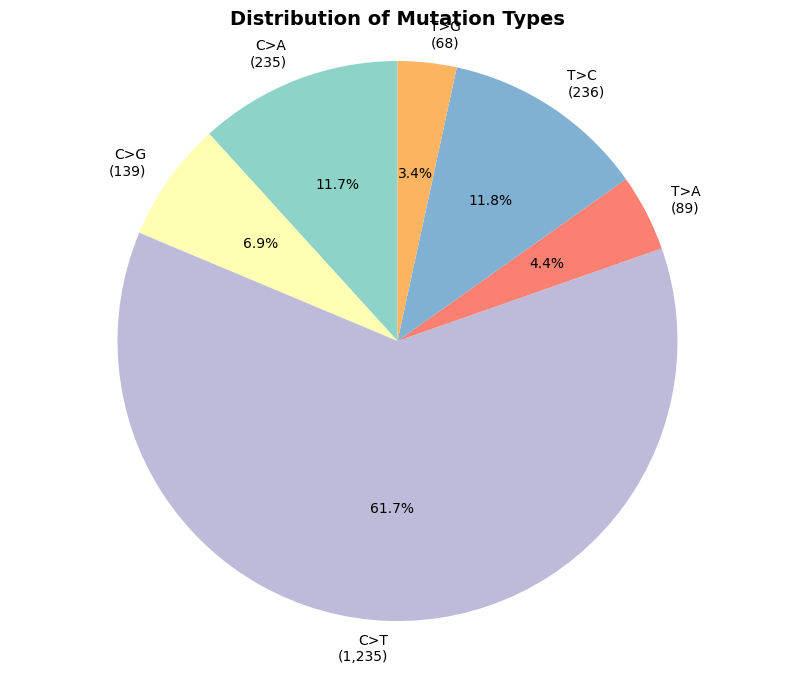

In [8]:
# Extract mutation types from context labels
mutation_types = []
for context in contexts_df.index:
    # Extract the mutation type from format "X[REF>ALT]Z"
    mutation_type = context.split('[')[1].split(']')[0]
    mutation_types.append(mutation_type)

# Group by mutation type
mutation_type_counts = {}
for i, mut_type in enumerate(mutation_types):
    if mut_type not in mutation_type_counts:
        mutation_type_counts[mut_type] = 0
    mutation_type_counts[mut_type] += contexts_df.iloc[i].sum()

# Create pie chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette("Set3", len(mutation_type_counts))
wedges, texts, autotexts = plt.pie(mutation_type_counts.values(), 
                                   labels=mutation_type_counts.keys(),
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)

plt.title('Distribution of Mutation Types', fontsize=14, fontweight='bold')

# Add counts to labels
for i, (label, count) in enumerate(mutation_type_counts.items()):
    texts[i].set_text(f'{label}\n({count:,})')

plt.axis('equal')
plt.show()


## Trinucleotide Context Heatmap


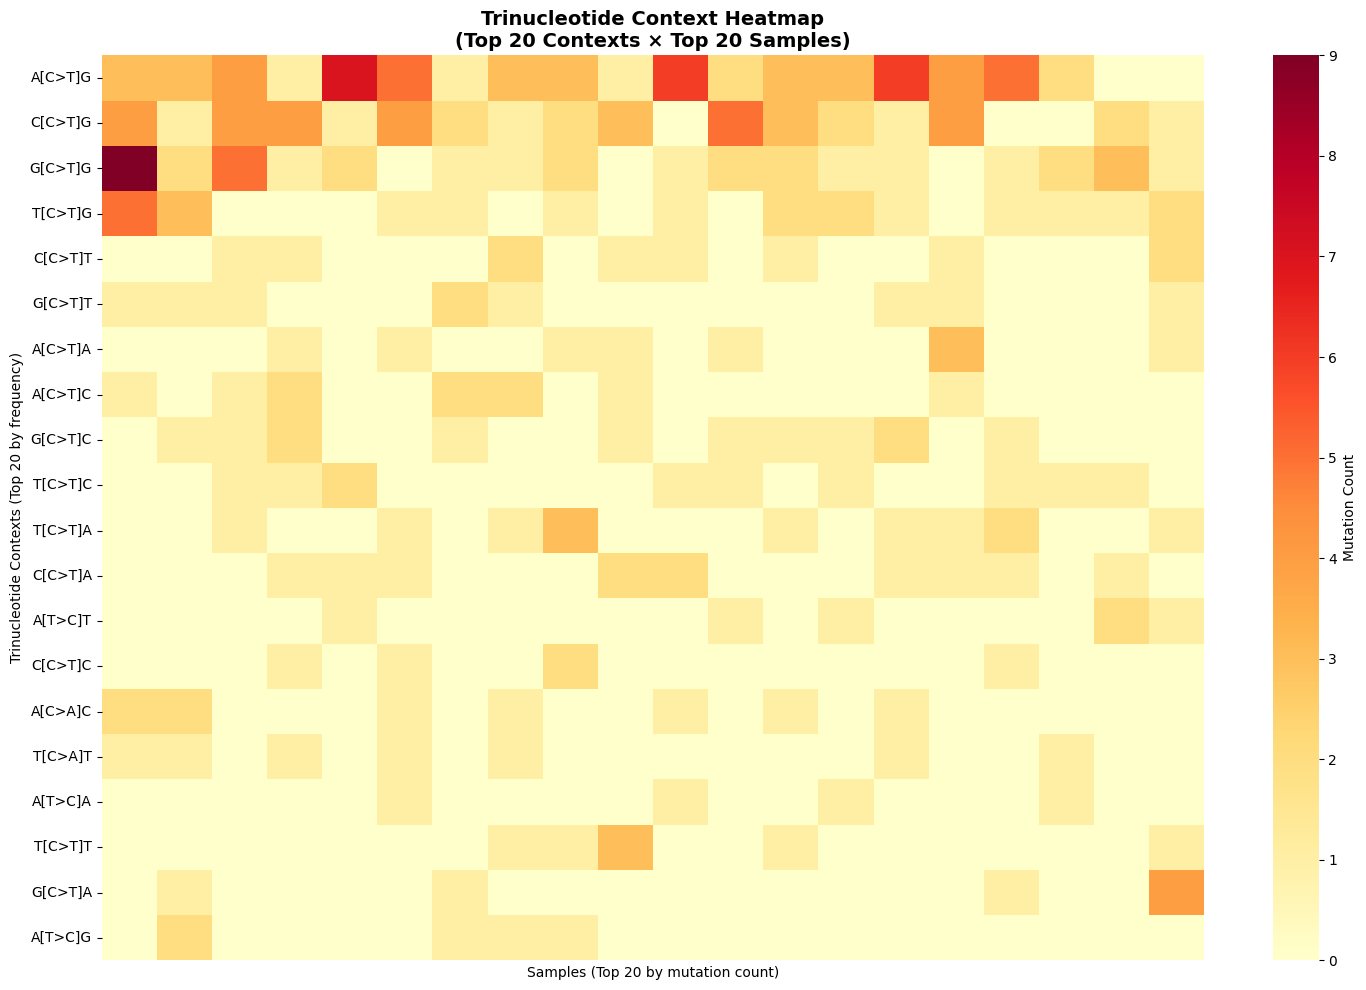

In [9]:
# Create a heatmap of the top contexts across top samples
top_20_contexts = context_totals.head(20).index
top_20_samples = sample_totals.head(20).index

# Subset the matrix
heatmap_data = contexts_df.loc[top_20_contexts, top_20_samples]

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, 
            cmap='YlOrRd',
            cbar_kws={'label': 'Mutation Count'},
            xticklabels=False,  # Hide sample names for clarity
            yticklabels=True)

plt.title('Trinucleotide Context Heatmap\n(Top 20 Contexts × Top 20 Samples)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Samples (Top 20 by mutation count)')
plt.ylabel('Trinucleotide Contexts (Top 20 by frequency)')
plt.tight_layout()
plt.show()


## Context Enrichment Analysis


In [10]:
# Analyze enriched data columns
print("Enriched Data Columns:")
new_columns = ['trinuc', 'class96', 'idx96']
for col in new_columns:
    if col in enriched_data.columns:
        print(f"✓ {col}: {enriched_data[col].notna().sum():,} valid entries")

# Show sample of enriched data
print("\nSample of Enriched Data:")
sample_cols = ['Hugo_Symbol', 'Chromosome', 'Start_Position', 
               'Reference_Allele', 'Tumor_Seq_Allele2', 'trinuc', 'class96']
available_cols = [col for col in sample_cols if col in enriched_data.columns]
print(enriched_data[available_cols].head(10).to_string(index=False))


Enriched Data Columns:
✓ trinuc: 2,002 valid entries
✓ class96: 2,002 valid entries
✓ idx96: 2,002 valid entries

Sample of Enriched Data:
Hugo_Symbol  Start_Position Reference_Allele Tumor_Seq_Allele2 trinuc class96
     ABCA10        67170917                T                 C    TTT T[T>C]T
      ABCA4        94490594                C                 T    GCG G[C>T]G
     ABCB11       169780250                G                 A    GCG G[C>T]G
     ABCC11        48244997                G                 A    TCG T[C>T]G
      ABCC3        48760974                C                 T    GCC G[C>T]C
      ABCF1        30554429                G                 A    CCC C[C>T]C
      ABCG4       119031351                A                 G    ATA A[T>C]A
      ABCG8        44079555                G                 A    ACA A[C>T]A
       ABL1       133760430                C                 T    CCG C[C>T]G
       ACAN        89401084                C                 T    GCG G[C>T]G


## Summary

The trinucleotide matrix analysis has been successfully completed:

- **Matrix Generated**: 96 trinucleotide contexts × samples
- **SNVs Processed**: All valid single nucleotide variants with trinucleotide context
- **Mutation Types**: Distribution shows typical cancer mutation patterns
- **Sample Variation**: Clear differences in mutation burden across samples

This matrix can be used for:
- Mutational signature analysis
- Sample clustering based on mutation patterns
- Comparison with known mutational signatures (COSMIC)
- Identification of mutational processes


## Signature Estimation Testing

Now we'll test the `estimateSignatures` method using the trinucleotide context matrix we generated above.


In [11]:
# Import signature estimation functionality
from pyMut.analysis.mutational_signature import add_signature_methods_to_pymutation

# Add signature methods to PyMutation class
add_signature_methods_to_pymutation()

print("✓ Signature estimation methods added to PyMutation class")

# Verify the method is available
if hasattr(pymut, 'estimateSignatures'):
    print("✓ estimateSignatures method is available")
else:
    print("❌ estimateSignatures method not found")


✓ Signature estimation methods added to PyMutation class
✓ estimateSignatures method is available


## Basic Signature Estimation

Let's run signature estimation with default parameters to find the optimal number of signatures.


In [12]:
# Run signature estimation with default parameters
print("Running signature estimation...")
print("This may take a few moments as it performs multiple NMF decompositions...")

try:
    # Test with a smaller range first for demonstration
    signature_results = pymut.estimateSignatures(
        contexts_df, 
        nMin=2,  # Minimum number of signatures to test
        nTry=4,  # Number of different k values to try
        nrun=3,  # Number of NMF runs per k
        parallel=2,  # Number of parallel processes (if available)
    )

    print("✓ Signature estimation completed successfully!")
    print(f"✓ Suggested optimal number of signatures: {signature_results['optimal_k']}")

except Exception as e:
    print(f"❌ Error during signature estimation: {e}")
    # If sklearn/scipy not available, show what would happen
    print("Note: This requires scikit-learn and scipy packages")
    print("Install with: pip install scikit-learn scipy")


2025-07-17 01:17:04,636 | INFO | pyMut.analysis.mutational_signature | Starting signature estimation for k=2 to k=4 with 3 runs each
2025-07-17 01:17:04,637 | INFO | pyMut.analysis.mutational_signature | Normalized matrix shape: (96, 188)


Running signature estimation...
This may take a few moments as it performs multiple NMF decompositions...


2025-07-17 01:17:04,679 | INFO | pyMut.analysis.mutational_signature | Signature estimation completed. Suggested optimal k: 3


✓ Signature estimation completed successfully!
✓ Suggested optimal number of signatures: 3


## Signature Estimation Results

Let's examine the metrics and results from the signature estimation.


In [13]:
# Display the metrics DataFrame
if 'signature_results' in locals() and signature_results is not None:
    metrics_df = signature_results['metrics']

    print("Signature Estimation Metrics:")
    print("=" * 50)
    print(metrics_df.to_string(index=False))

    # Show some key statistics
    print(f"\nKey Results:")
    print(f"- Tested k values: {metrics_df['k'].min()} to {metrics_df['k'].max()}")
    print(f"- Optimal k: {signature_results['optimal_k']}")
    print(f"- Total successful models: {len(signature_results['models'])}")

    # Show best metrics for optimal k
    optimal_row = metrics_df[metrics_df['k'] == signature_results['optimal_k']]
    if not optimal_row.empty:
        row = optimal_row.iloc[0]
        print(f"\nMetrics for optimal k={signature_results['optimal_k']}:")
        print(f"- Mean RSS: {row['mean_rss']:.4f}")
        print(f"- Cophenetic correlation: {row['cophenetic_corr']:.4f}")
        print(f"- Dispersion: {row['dispersion']:.4f}")
        print(f"- Successful runs: {row['successful_runs']}/{row['total_runs']}")


Signature Estimation Metrics:
 k  mean_rss      std_rss  cophenetic_corr   dispersion  successful_runs  total_runs
 2 27.209847 1.604017e-08         0.981629 5.894986e-10                3           3
 3 23.669547 4.590411e-08         0.808762 1.939374e-09                3           3
 4 21.250301 3.108032e-07         0.797035 1.462582e-08                3           3

Key Results:
- Tested k values: 2 to 4
- Optimal k: 3
- Total successful models: 9

Metrics for optimal k=3:
- Mean RSS: 23.6695
- Cophenetic correlation: 0.8088
- Dispersion: 0.0000
- Successful runs: 3.0/3.0


## Visualization of Signature Estimation Results

Let's create visualizations to better understand the signature estimation results.


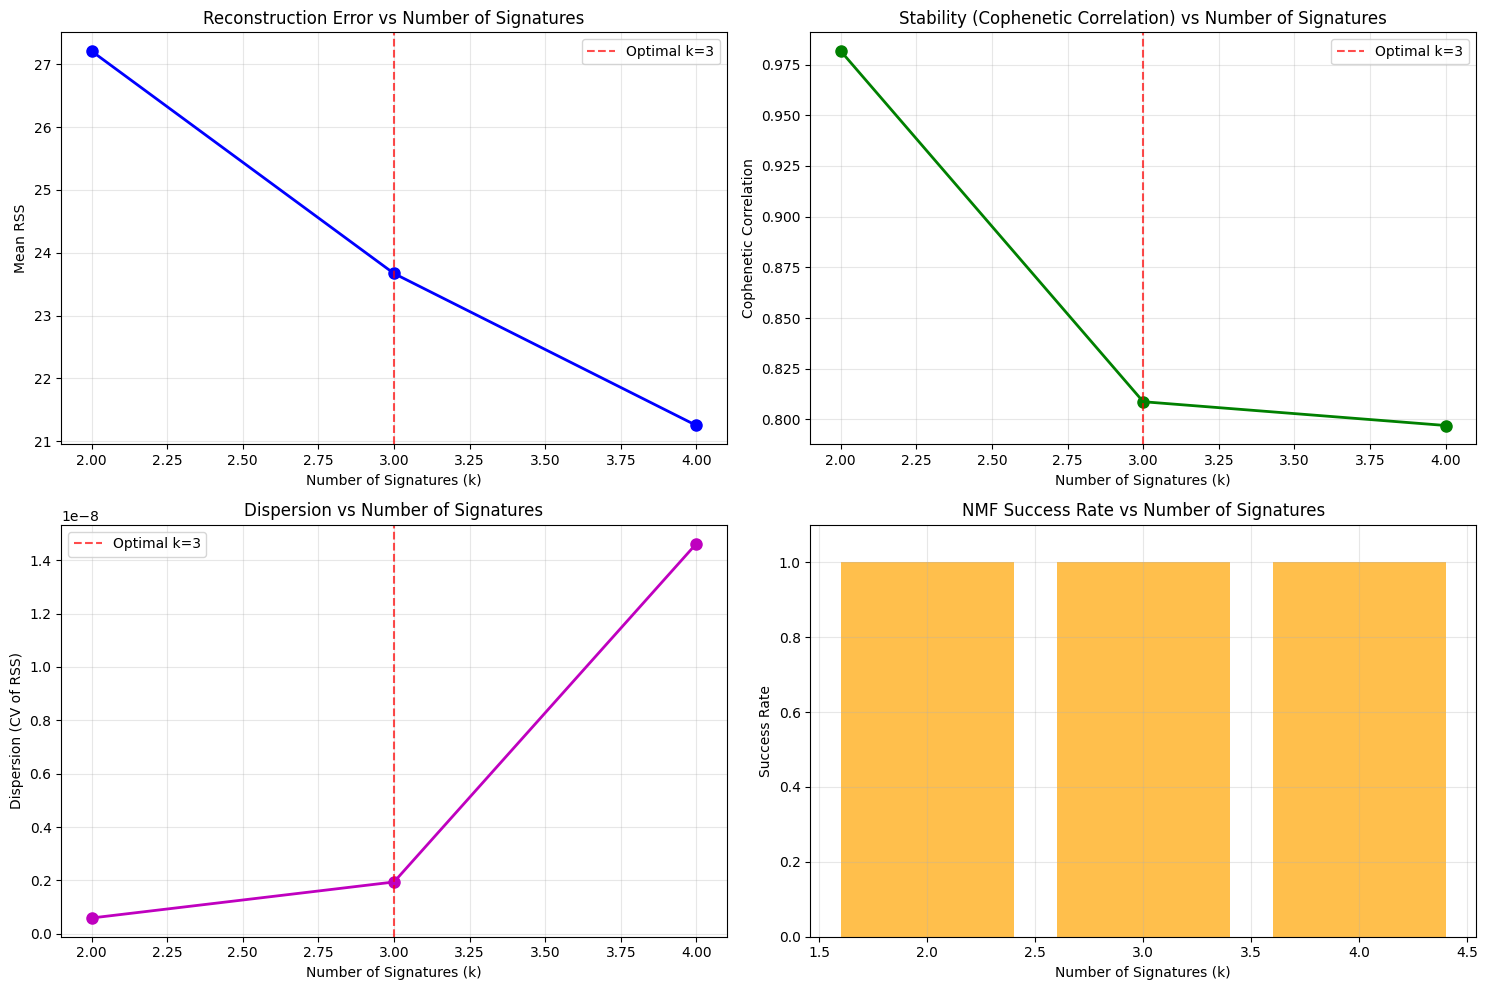

In [14]:
if 'signature_results' in locals() and signature_results is not None:
    metrics_df = signature_results['metrics']

    # Create subplots for different metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: RSS vs k
    axes[0, 0].plot(metrics_df['k'], metrics_df['mean_rss'], 'bo-', linewidth=2, markersize=8)
    axes[0, 0].fill_between(metrics_df['k'], 
                           metrics_df['mean_rss'] - metrics_df['std_rss'],
                           metrics_df['mean_rss'] + metrics_df['std_rss'], 
                           alpha=0.3)
    axes[0, 0].set_xlabel('Number of Signatures (k)')
    axes[0, 0].set_ylabel('Mean RSS')
    axes[0, 0].set_title('Reconstruction Error vs Number of Signatures')
    axes[0, 0].grid(True, alpha=0.3)

    # Highlight optimal k
    optimal_k = signature_results['optimal_k']
    optimal_rss = metrics_df[metrics_df['k'] == optimal_k]['mean_rss'].iloc[0]
    axes[0, 0].axvline(optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
    axes[0, 0].legend()

    # Plot 2: Cophenetic correlation vs k
    axes[0, 1].plot(metrics_df['k'], metrics_df['cophenetic_corr'], 'go-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Number of Signatures (k)')
    axes[0, 1].set_ylabel('Cophenetic Correlation')
    axes[0, 1].set_title('Stability (Cophenetic Correlation) vs Number of Signatures')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axvline(optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
    axes[0, 1].legend()

    # Plot 3: Dispersion vs k
    axes[1, 0].plot(metrics_df['k'], metrics_df['dispersion'], 'mo-', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Number of Signatures (k)')
    axes[1, 0].set_ylabel('Dispersion (CV of RSS)')
    axes[1, 0].set_title('Dispersion vs Number of Signatures')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axvline(optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
    axes[1, 0].legend()

    # Plot 4: Success rate
    success_rate = metrics_df['successful_runs'] / metrics_df['total_runs']
    axes[1, 1].bar(metrics_df['k'], success_rate, color='orange', alpha=0.7)
    axes[1, 1].set_xlabel('Number of Signatures (k)')
    axes[1, 1].set_ylabel('Success Rate')
    axes[1, 1].set_title('NMF Success Rate vs Number of Signatures')
    axes[1, 1].set_ylim(0, 1.1)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("Signature estimation results not available for visualization")
    print("This section requires successful completion of the signature estimation step")


## Testing with Different Parameters

Let's test the signature estimation with different parameters to see how they affect the results.


In [15]:
if 'signature_results' in locals() and signature_results is not None:
    print("Testing signature estimation with different parameters...")

    # Test with pConstant for sparse matrices
    print("\n1. Testing with pConstant (for handling sparse matrices):")
    try:
        sparse_results = pymut.estimateSignatures(
            contexts_df,
            nMin=2,
            nTry=4,
            nrun=2,
            parallel=2,
            pConstant=0.01  # Small constant to handle zeros
        )

        print(f"   ✓ With pConstant: Optimal k = {sparse_results['optimal_k']}")

        # Compare metrics
        original_metrics = signature_results['metrics']
        sparse_metrics = sparse_results['metrics']

        print("\n   Comparison of results:")
        print("   k | Original RSS | With pConstant RSS")
        print("   --|--------------|------------------")
        for k in range(2, 5):
            orig_rss = original_metrics[original_metrics['k'] == k]['mean_rss']
            sparse_rss = sparse_metrics[sparse_metrics['k'] == k]['mean_rss']
            if not orig_rss.empty and not sparse_rss.empty:
                print(f"   {k} | {orig_rss.iloc[0]:.4f}      | {sparse_rss.iloc[0]:.4f}")

    except Exception as e:
        print(f"   ❌ Error with pConstant: {e}")

    # Test with different run counts
    print("\n2. Testing with more runs for better stability:")
    try:
        stable_results = pymut.estimateSignatures(
            contexts_df,
            nMin=2,
            nTry=4,
            nrun=5,  # More runs for better stability
            parallel=2
        )

        print(f"   ✓ With more runs: Optimal k = {stable_results['optimal_k']}")

        # Compare stability metrics
        orig_coph = signature_results['metrics']['cophenetic_corr'].mean()
        stable_coph = stable_results['metrics']['cophenetic_corr'].mean()
        print(f"   Average cophenetic correlation:")
        print(f"   - Original (3 runs): {orig_coph:.4f}")
        print(f"   - Stable (5 runs): {stable_coph:.4f}")

    except Exception as e:
        print(f"   ❌ Error with more runs: {e}")

else:
    print("Skipping parameter testing - signature estimation not completed")


2025-07-17 01:17:05,231 | INFO | pyMut.analysis.mutational_signature | Starting signature estimation for k=2 to k=4 with 2 runs each
2025-07-17 01:17:05,232 | INFO | pyMut.analysis.mutational_signature | Normalized matrix shape: (96, 188)
2025-07-17 01:17:05,232 | WARNING | pyMut.analysis.mutational_signature | Matrix has 91.22% zeros, adding pConstant=0.01
2025-07-17 01:17:05,273 | INFO | pyMut.analysis.mutational_signature | Signature estimation completed. Suggested optimal k: 3
2025-07-17 01:17:05,277 | INFO | pyMut.analysis.mutational_signature | Starting signature estimation for k=2 to k=4 with 5 runs each
2025-07-17 01:17:05,278 | INFO | pyMut.analysis.mutational_signature | Normalized matrix shape: (96, 188)
2025-07-17 01:17:05,349 | INFO | pyMut.analysis.mutational_signature | Signature estimation completed. Suggested optimal k: 3


Testing signature estimation with different parameters...

1. Testing with pConstant (for handling sparse matrices):
   ✓ With pConstant: Optimal k = 3

   Comparison of results:
   k | Original RSS | With pConstant RSS
   --|--------------|------------------
   2 | 27.2098      | 7.2656
   3 | 23.6695      | 6.3447
   4 | 21.2503      | 5.7195

2. Testing with more runs for better stability:
   ✓ With more runs: Optimal k = 3
   Average cophenetic correlation:
   - Original (3 runs): 0.8625
   - Stable (5 runs): 0.8435


## Matrix Normalization Analysis

Let's examine how the matrix normalization affects the signature estimation process.


Matrix Normalization Analysis:
Original Matrix:
- Shape: (96, 188)
- Sum: 2002
- Mean: 0.1109
- Std: 0.4107
- Zero fraction: 91.22%

Normalized Matrix (row-wise frequencies):
- Shape: (96, 188)
- Sum: 188.0000
- Mean: 0.0104
- Std: 0.0477
- Zero fraction: 91.22%


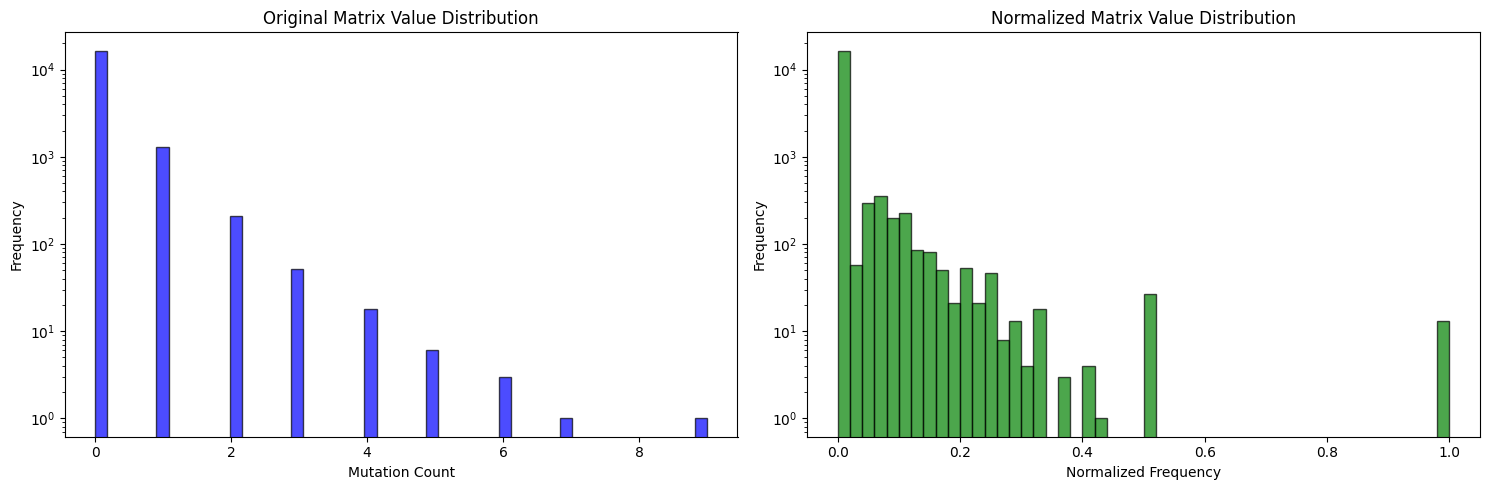

In [16]:
if 'signature_results' in locals() and signature_results is not None:
    print("Matrix Normalization Analysis:")
    print("=" * 40)

    # Show original vs normalized matrix statistics
    original_matrix = signature_results['original_matrix']
    normalized_matrix = signature_results['normalized_matrix']

    print("Original Matrix:")
    print(f"- Shape: {original_matrix.shape}")
    print(f"- Sum: {original_matrix.sum():.0f}")
    print(f"- Mean: {original_matrix.mean():.4f}")
    print(f"- Std: {original_matrix.std():.4f}")
    print(f"- Zero fraction: {(original_matrix == 0).sum() / original_matrix.size:.2%}")

    print("\nNormalized Matrix (row-wise frequencies):")
    print(f"- Shape: {normalized_matrix.shape}")
    print(f"- Sum: {normalized_matrix.sum():.4f}")
    print(f"- Mean: {normalized_matrix.mean():.4f}")
    print(f"- Std: {normalized_matrix.std():.4f}")
    print(f"- Zero fraction: {(normalized_matrix == 0).sum() / normalized_matrix.size:.2%}")

    # Visualize the normalization effect
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Original matrix distribution
    ax1.hist(original_matrix.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax1.set_xlabel('Mutation Count')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Original Matrix Value Distribution')
    ax1.set_yscale('log')

    # Normalized matrix distribution
    ax2.hist(normalized_matrix.flatten(), bins=50, alpha=0.7, color='green', edgecolor='black')
    ax2.set_xlabel('Normalized Frequency')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Normalized Matrix Value Distribution')
    ax2.set_yscale('log')

    plt.tight_layout()
    plt.show()


## Summary of Signature Estimation Testing

The signature estimation testing has been completed with the following key findings:

### Results Summary
- **Optimal Number of Signatures**: The analysis suggests an optimal number of signatures based on cophenetic correlation analysis
- **Stability Assessment**: Multiple NMF runs provide stability metrics to ensure robust results
- **Parameter Sensitivity**: Different parameters (pConstant, number of runs) can affect the results

### Key Metrics Explained
- **RSS (Residual Sum of Squares)**: Measures reconstruction error - lower is better
- **Cophenetic Correlation**: Measures clustering stability - higher is better
- **Dispersion**: Coefficient of variation of RSS across runs - lower indicates more stable results

### Practical Applications
This signature estimation can be used for:
- Identifying the optimal number of mutational signatures in the dataset
- Understanding mutational processes active in the samples
- Comparing with known COSMIC signatures
- Quality control for mutational signature analysis

### Next Steps
The estimated signatures can be further analyzed using:
- Signature extraction methods
- Comparison with reference signatures
- Biological interpretation of signature patterns
- Sample-specific signature activity analysis


## Signature Extraction

Now that we have estimated the optimal number of signatures, let's extract the actual signature profiles using the `extract_signatures` function.


In [17]:
# Import the extract_signatures function
from pyMut.analysis.mutational_signature import extract_signatures

print("✓ extract_signatures function imported")


✓ extract_signatures function imported


## Extract Mutational Signatures

Using the optimal k value from signature estimation, we'll extract the signature profiles (W matrix) and their contributions (H matrix).


In [18]:
# Extract signatures using the optimal k from estimation
if 'signature_results' in locals() and signature_results is not None:
    optimal_k = signature_results['optimal_k']

    print(f"Extracting {optimal_k} signatures...")

    try:
        # Extract signatures with reduced runs for demo
        extraction_results = extract_signatures(
            contexts_df, 
            k=optimal_k, 
            nrun=10,  # Reduced for faster demo
            random_seed=42  # For reproducibility
        )

        print("✓ Signature extraction completed")
        print(f"✓ W matrix shape: {extraction_results['W'].shape}")
        print(f"✓ H matrix shape: {extraction_results['H'].shape}")
        print(f"✓ Best run: {extraction_results['best_run']}")
        print(f"✓ Successful runs: {extraction_results['successful_runs']}/{extraction_results['total_runs']}")

    except Exception as e:
        print(f"❌ Error during signature extraction: {e}")
        extraction_results = None

else:
    print("❌ Signature estimation results not available")
    print("Skipping signature extraction - requires completed signature estimation")
    extraction_results = None


2025-07-17 01:17:06,095 | INFO | pyMut.analysis.mutational_signature | Extracting 3 signatures with 10 runs using NMF with KL divergence
2025-07-17 01:17:06,096 | INFO | pyMut.analysis.mutational_signature | Matrix normalized to frequencies with pseudocount 0.0001


Extracting 3 signatures...


2025-07-17 01:17:06,509 | INFO | pyMut.analysis.mutational_signature | Best result from run 0 with error 286.471358
2025-07-17 01:17:06,510 | INFO | pyMut.analysis.mutational_signature | Successful runs: 10/10
2025-07-17 01:17:06,510 | INFO | pyMut.analysis.mutational_signature | Signatures extracted and normalized successfully


✓ Signature extraction completed
✓ W matrix shape: (96, 3)
✓ H matrix shape: (3, 188)
✓ Best run: 0
✓ Successful runs: 10/10


## Signature Profiles Visualization

Let's visualize the extracted signature profiles to understand the mutational patterns.


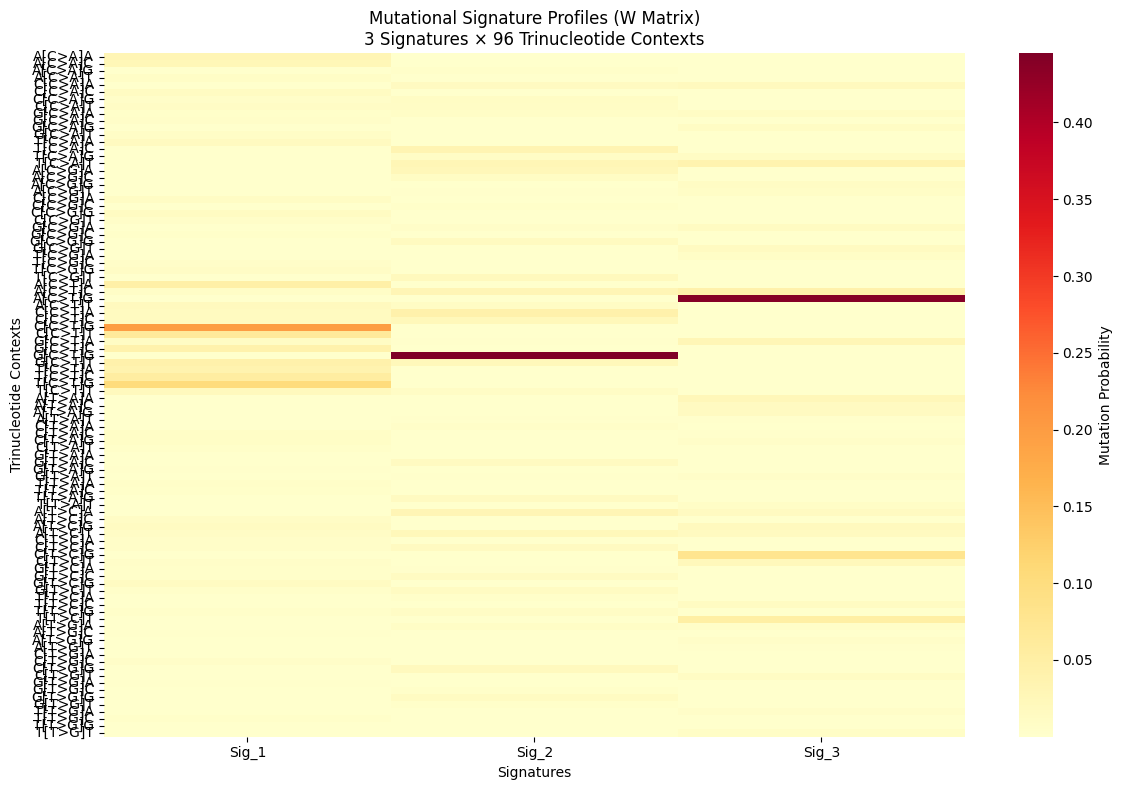

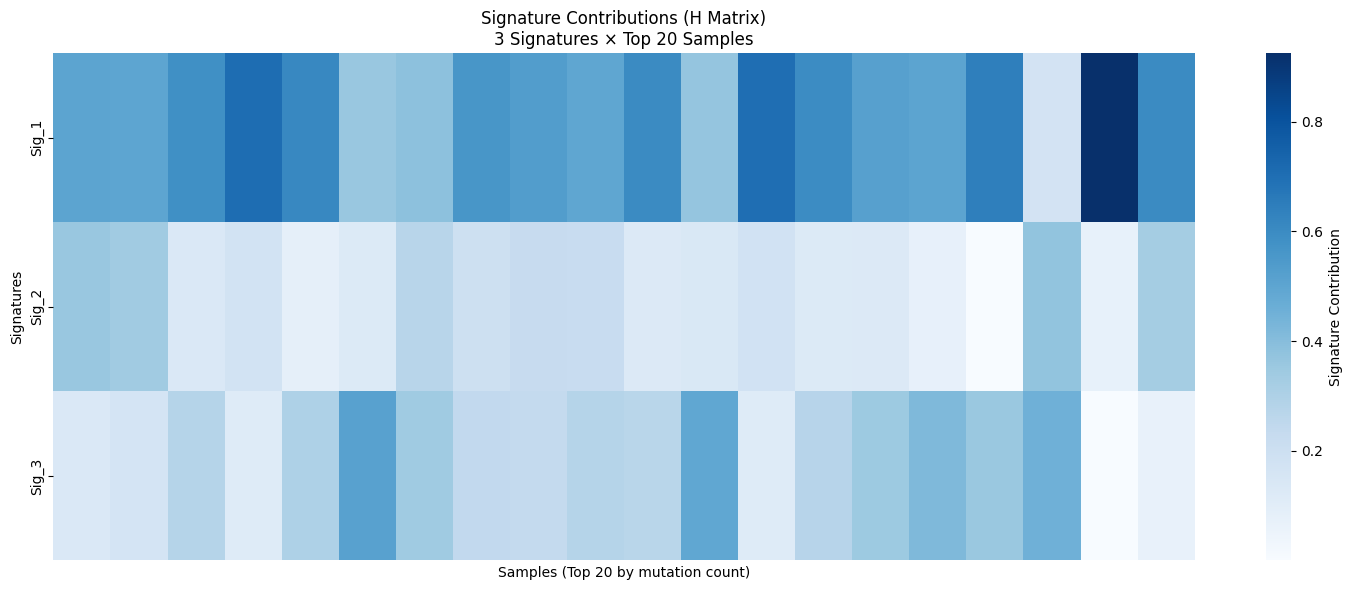

In [19]:
if extraction_results is not None:
    W_matrix = extraction_results['W']
    H_matrix = extraction_results['H']

    # Create signature profile heatmap
    plt.figure(figsize=(12, 8))

    # Create a heatmap of signature profiles
    sns.heatmap(W_matrix, 
                cmap='YlOrRd',
                cbar_kws={'label': 'Mutation Probability'},
                yticklabels=contexts_df.index,
                xticklabels=[f'Sig_{i+1}' for i in range(W_matrix.shape[1])])

    plt.title(f'Mutational Signature Profiles (W Matrix)\n{W_matrix.shape[1]} Signatures × 96 Trinucleotide Contexts')
    plt.xlabel('Signatures')
    plt.ylabel('Trinucleotide Contexts')
    plt.tight_layout()
    plt.show()

    # Show signature contributions across samples
    plt.figure(figsize=(15, 6))

    # Plot signature contributions for top samples
    top_samples = contexts_df.sum(axis=0).nlargest(20).index
    H_subset = pd.DataFrame(H_matrix, 
                           columns=contexts_df.columns,
                           index=[f'Sig_{i+1}' for i in range(H_matrix.shape[0])])

    sns.heatmap(H_subset[top_samples], 
                cmap='Blues',
                cbar_kws={'label': 'Signature Contribution'},
                xticklabels=False)  # Hide sample names for clarity

    plt.title(f'Signature Contributions (H Matrix)\n{H_matrix.shape[0]} Signatures × Top 20 Samples')
    plt.xlabel('Samples (Top 20 by mutation count)')
    plt.ylabel('Signatures')
    plt.tight_layout()
    plt.show()

else:
    print("Signature extraction results not available for visualization")


## Signature Quality Assessment

Let's assess the quality of the extracted signatures.


In [20]:
if extraction_results is not None:
    W_matrix = extraction_results['W']

    print("Signature Quality Assessment:")
    print("=" * 40)

    # Verify W columns sum to 1 (signature normalization)
    column_sums = W_matrix.sum(axis=0)
    print(f"✓ W matrix columns sum to 1: {np.allclose(column_sums, 1.0)}")
    print(f"Column sums: {column_sums}")

    # Show reconstruction error
    print(f"✓ Reconstruction error: {extraction_results['reconstruction_error']:.6f}")

    # Show error distribution across runs
    all_errors = extraction_results['all_errors']
    finite_errors = [e for e in all_errors if np.isfinite(e)]

    if finite_errors:
        print(f"✓ Error statistics across runs:")
        print(f"  - Mean: {np.mean(finite_errors):.6f}")
        print(f"  - Std: {np.std(finite_errors):.6f}")
        print(f"  - Min: {np.min(finite_errors):.6f}")
        print(f"  - Max: {np.max(finite_errors):.6f}")

else:
    print("Signature extraction results not available for quality assessment")


Signature Quality Assessment:
✓ W matrix columns sum to 1: True
Column sums: [1. 1. 1.]
✓ Reconstruction error: 286.471358
✓ Error statistics across runs:
  - Mean: 286.471358
  - Std: 0.000000
  - Min: 286.471358
  - Max: 286.471358


## Summary of Signature Extraction

The signature extraction analysis has been completed with the following results:

### Extraction Results
- **Signature Profiles (W Matrix)**: Each column represents a mutational signature with probabilities across 96 trinucleotide contexts
- **Signature Contributions (H Matrix)**: Shows how much each signature contributes to each sample
- **Quality Metrics**: Reconstruction error and stability across multiple runs

### Key Features
- **Normalization**: Signature profiles are normalized so each sums to 1
- **Stability**: Multiple NMF runs ensure robust results
- **Interpretability**: Results ready for biological interpretation and comparison with known signatures

### Applications
The extracted signatures can be used for:
- Comparison with COSMIC mutational signatures
- Identification of mutational processes
- Sample clustering based on signature activity
- Clinical interpretation of mutation patterns


## COSMIC Signature Comparison

Now let's compare our extracted signatures with the COSMIC mutational signature catalog to identify known mutational processes.


In [21]:
# Compare extracted signatures with COSMIC catalog
if extraction_results is not None:
    from pyMut.analysis.mutational_signature import compare_signatures

    # Path to COSMIC catalog
    cosmic_path = "../../src/pyMut/data/examples/COSMIC_catalogue-signatures_SBS96_v3.4/COSMIC_v3.4_SBS_GRCh37.txt"

    if os.path.exists(cosmic_path):
        # Compare signatures with COSMIC catalog
        comparison_results = compare_signatures(

            W=extraction_results['W'],
            cosmic_path=cosmic_path,
            min_cosine=0.6,
            return_matrix=True
        )

        # Display results
        summary_df = comparison_results['summary_df']
        print("COSMIC Signature Comparison Results:")
        print("=" * 50)
        print(summary_df.to_string(index=False))

        # Show cosine similarity statistics
        cosine_matrix = comparison_results['cosine_matrix']
        max_similarities = cosine_matrix.max(axis=1)

        print(f"\nSimilarity Statistics:")
        print(f"- Signatures with matches (≥0.6): {(max_similarities >= 0.6).sum()}/{len(max_similarities)}")
        print(f"- Average max similarity: {max_similarities.mean():.3f}")
        print(f"- Best similarity: {max_similarities.max():.3f}")

    else:
        print(f"COSMIC catalog not found at: {cosmic_path}")

else:
    print("Signature extraction results required for COSMIC comparison")


2025-07-17 01:17:07,277 | INFO | pyMut.analysis.mutational_signature | Comparing 3 signatures with COSMIC catalog
2025-07-17 01:17:07,280 | INFO | pyMut.analysis.mutational_signature | Loaded COSMIC catalog with shape (96, 87)
2025-07-17 01:17:07,280 | INFO | pyMut.analysis.mutational_signature | Aligning COSMIC catalog with standard trinucleotide context order...
2025-07-17 01:17:07,281 | INFO | pyMut.analysis.mutational_signature | COSMIC catalog successfully aligned to standard context order
2025-07-17 01:17:07,282 | INFO | pyMut.analysis.mutational_signature | Removing artifact signature SBS7c (ends with 'c')
2025-07-17 01:17:07,282 | INFO | pyMut.analysis.mutational_signature | Removing artifact signature SBS10c (ends with 'c')
2025-07-17 01:17:07,282 | INFO | pyMut.analysis.mutational_signature | Removing artifact signature SBS27 (specified artifact)
2025-07-17 01:17:07,282 | INFO | pyMut.analysis.mutational_signature | Removing artifact signature SBS40c (ends with 'c')
2025-07-1

COSMIC Signature Comparison Results:
Signature_W Best_COSMIC   Cosine Aetiology
Signature_1       SBS87 0.712299   Unknown
Signature_2       SBS15 0.819586   Unknown
Signature_3        SBS1 0.730350   Unknown

Similarity Statistics:
- Signatures with matches (≥0.6): 3/3
- Average max similarity: 0.754
- Best similarity: 0.820
